In [3]:
from io import BytesIO
from PIL import Image

def convert_to_jpeg(im):
    with BytesIO() as f:
        im.convert('RGB').save(f, format='JPEG')
        f.seek(0)
        img = Image.open(f)
        img.load()
        return img

In [4]:
import numpy as np
import os
import torch
import time
from transformers import AutoImageProcessor, SwinForImageClassification
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.utils.class_weight import compute_class_weight
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from torch.optim import Adam
from torch.nn import CrossEntropyLoss, BCELoss
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from torch.cuda.amp import autocast, GradScaler  # For mixed precision training
from tqdm import tqdm

train_path = "./charteye/train"
val_path = "./charteye/val"

image_processor = AutoImageProcessor.from_pretrained("microsoft/swin-large-patch4-window7-224")
model = SwinForImageClassification.from_pretrained("microsoft/swin-large-patch4-window7-224", num_labels=2, ignore_mismatched_sizes=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-large-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1536]) in the checkpoint and torch.Size([2, 1536]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, Subset, ConcatDataset
from torchvision import transforms
from torchvision.datasets import ImageFolder
import random

# Constants
TARGET_TOTAL_SIZE = 30000
CHART_CLASS = 1
GENERAL_CLASS = 0

# Define transformation object
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
])

# 1. Load PACS, DomainNet, and Charteye datasets
print("Loading datasets...")
pacs_dataset = load_dataset("flwrlabs/pacs", split="train")
domainnet_dataset = load_dataset("wltjr1007/DomainNet", split="train")
charteye_dataset = ImageFolder("./charteye/train", transform=None)  # Transform applied later

# Assign labels directly: General (0) for PACS and DomainNet, Charts (1) for Charteye
pacs_dataset = pacs_dataset.map(lambda example: {"label": GENERAL_CLASS})
domainnet_labels = domainnet_dataset["label"]

# Determine sizes for sampling
pacs_size = len(pacs_dataset)
charteye_size = len(charteye_dataset)
domainnet_sample_size = TARGET_TOTAL_SIZE - pacs_size

Loading datasets...


Using the latest cached version of the dataset since flwrlabs/pacs couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at C:\Users\Stefano\.cache\huggingface\datasets\flwrlabs___pacs\default\0.0.0\394113073258ead631f617d2e13bb377c0715c4b (last modified on Sat Dec 14 21:20:16 2024).


In [6]:
# 2. Stratified sampling from DomainNet
print(f"Sampling {domainnet_sample_size} examples from DomainNet...")
sampled_indices, _ = train_test_split(
    range(len(domainnet_labels)),
    train_size=domainnet_sample_size,
    stratify=domainnet_labels,
    random_state=42
)
domainnet_dataset = domainnet_dataset.select(sampled_indices)

# 3. Define custom PyTorch-compatible datasets
class HuggingFaceDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        sample = self.dataset[idx]
        image = sample["image"]
        label = sample["label"]
        if self.transform:
            image = self.transform(image)
        return image, label

class CharteyeDataset(Dataset):
    def __init__(self, dataset, label, transform=None):
        self.dataset = dataset
        self.label = label
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, _ = self.dataset[idx]
        if self.transform:
            image = self.transform(image)
        return image, self.label

# Wrap datasets
pacs = HuggingFaceDataset(pacs_dataset, transform=transform)
domainnet = HuggingFaceDataset(domainnet_dataset, transform=transform)
charteye = CharteyeDataset(charteye_dataset, CHART_CLASS, transform=transform)

Sampling 20009 examples from DomainNet...


In [7]:
# 4. Combine datasets
print("Combining datasets...")
# combined_dataset = ConcatDataset([pacs, domainnet, charteye])
combined_dataset = ConcatDataset([pacs, charteye])

Combining datasets...


In [8]:
# 5. Split into train and validation sets (stratified split)
print("Splitting dataset...")
labels = [0 if i < TARGET_TOTAL_SIZE else 1 for i in range(len(combined_dataset))]
indices = list(range(len(combined_dataset)))

train_indices, val_indices = train_test_split(
    indices, test_size=0.2, stratify=labels, random_state=42
)

train_dataset = Subset(combined_dataset, train_indices)
val_dataset = Subset(combined_dataset, val_indices)

Splitting dataset...


In [9]:
# 6. Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

# Final size report
print(f"Dataset sizes -> Total: {len(combined_dataset)}, Train: {len(train_dataset)}, Validation: {len(val_dataset)}")

Dataset sizes -> Total: 32914, Train: 26331, Validation: 6583


In [10]:
normalize_class_weights = True

In [ ]:
from torch.nn import CrossEntropyLoss, BCELoss

# Compute class weights based on the training dataset
# Assuming train_loader has (image, label) tuples
# all_labels = []
# for _, labels in train_loader:
#    all_labels.extend(labels.numpy())  # Collect all labels from the training set

all_labels = np.array(labels)[train_indices]
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(all_labels), y=all_labels)
class_weights = class_weights / class_weights.sum() if normalize_class_weights else class_weights
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Optimizer and loss function
optimizer = Adam(model.parameters(), lr=3e-6)

# Loss function with normalized class weights (optional)
loss_fn = CrossEntropyLoss(weight=class_weights) if len(class_weights) > 2 else BCELoss(weight=class_weights)

# Initialize the gradient scaler for mixed precision
scaler = GradScaler()

# Early stopping parameters
patience = 10  # Number of epochs with no improvement after which training will stop
best_val_loss = float('inf')  # Initialize to a large number
patience_counter = 0  # To count how many epochs have passed without improvement

# Training loop
num_epochs = 50

# Lists to store losses and predictions for plotting later
train_losses = []
val_losses = []
validation_labels = []
validation_predictions = []

for epoch in range(num_epochs):
    start_time = time.time()  # Record the start time for this epoch
    
    model.train()
    train_loss = 0
    
    # Create a tqdm progress bar for the training loop
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}", ncols=100, leave=False)

    for images, labels in train_loader_tqdm:
        images, labels = images.to(device), labels.to(device)

        # Mixed precision training
        optimizer.zero_grad()

        with autocast():  # Enables automatic mixed precision
            outputs = model(images).logits  # Get logits from the classification head
            loss = loss_fn(outputs, labels)

        # Backward pass and optimization
        scaler.scale(loss).backward()  # Scales the loss for precision
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Clip gradients
        scaler.step(optimizer)        # Optimizer step
        scaler.update()               # Updates the scaler
        
        train_loss += loss.item()

        # Update the progress bar with the current training loss
        train_loader_tqdm.set_postfix(train_loss=train_loss / (train_loader_tqdm.n + 1), refresh=True)

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)  # Store training loss

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss}")

    # Validation loop
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images).logits
            outputs = torch.clamp(outputs, min=-1e7, max=1e7)  # avoid extreme values
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()

            # Calculate accuracy
            preds = torch.argmax(outputs, dim=1)  # Predictions
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            # Save labels and predictions
            validation_labels.extend(labels.cpu().numpy())  # Save true labels
            validation_predictions.extend(preds.cpu().numpy())  # Save predictions
        
        for name, param in model.named_parameters():
            if param.grad is not None and torch.isnan(param.grad).any():
                print(f"NaN in gradients of {name}")

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)  # Store validation loss
    accuracy = correct / total
    print(f"Validation Loss: {avg_val_loss}, Accuracy: {accuracy * 100:.2f}%")
    
    # Check for early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0  # Reset counter as we have a new best model
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs")
            break  # Exit the training loop early
    
    # Calculate the elapsed time for this epoch
    end_time = time.time()  # Record the end time for this epoch
    epoch_duration = end_time - start_time  # Compute the duration
    print(f"Epoch {epoch + 1} completed in {epoch_duration:.2f} seconds\n")

Epoch 1/50:   0%|                                                           | 0/823 [00:00<?, ?it/s]

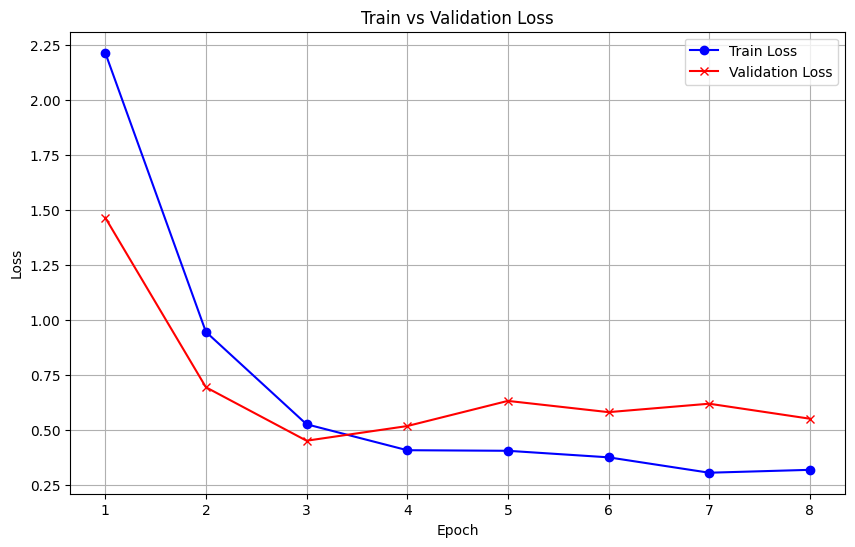

In [12]:
import matplotlib.pyplot as plt

# Plotting Train vs Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, epoch + 2), train_losses, label='Train Loss', color='blue', linestyle='-', marker='o')
plt.plot(range(1, epoch + 2), val_losses, label='Validation Loss', color='red', linestyle='-', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# After training is done, calculate performance metrics on the entire validation set
# Confusion Matrix
cm = confusion_matrix(validation_labels, validation_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(validation_labels), yticklabels=np.unique(validation_labels))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Calculate Accuracy, Precision, Recall, F1-Score
accuracy = accuracy_score(validation_labels, validation_predictions)
precision = precision_score(validation_labels, validation_predictions, average='weighted' if len(class_weights) > 2 else 'binary')  # Weighted for multi-class
recall = recall_score(validation_labels, validation_predictions, average='weighted' if len(class_weights) > 2 else 'binary')
f1 = f1_score(validation_labels, validation_predictions, average='weighted' if len(class_weights) > 2 else 'binary')

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision (Weighted): {precision:.2f}")
print(f"Recall (Weighted): {recall:.2f}")
print(f"F1-Score (Weighted): {f1:.2f}")

In [13]:
# Define the path to save the model weights
model_save_path = "./chart_detection_model.pt"

torch.save(model.state_dict(), model_save_path)

In [16]:
import torch

# Define the model architecture
image_processor = AutoImageProcessor.from_pretrained("microsoft/swin-large-patch4-window7-224")
model = SwinForImageClassification.from_pretrained("microsoft/swin-large-patch4-window7-224", num_labels=len(os.listdir(train_path)), ignore_mismatched_sizes=True)

# Load the saved weights
model.load_state_dict(torch.load("./model_weights.pt"))
model.to(device)  # Move the model to the appropriate device
model.eval()  # Set the model to evaluation mode

c:\Users\Stefano\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-large-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1536]) in the checkpoint and torch.Size([15, 1536]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([15]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to 

SwinForImageClassification(
  (swin): SwinModel(
    (embeddings): SwinEmbeddings(
      (patch_embeddings): SwinPatchEmbeddings(
        (projection): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): SwinEncoder(
      (layers): ModuleList(
        (0): SwinStage(
          (blocks): ModuleList(
            (0-1): 2 x SwinLayer(
              (layernorm_before): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
              (attention): SwinAttention(
                (self): SwinSelfAttention(
                  (query): Linear(in_features=192, out_features=192, bias=True)
                  (key): Linear(in_features=192, out_features=192, bias=True)
                  (value): Linear(in_features=192, out_features=192, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
                )
                (output): SwinSelfO

In [17]:
from PIL import Image

# Preprocessing transformations (same as during training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
])

# Load and preprocess a single image
image_path = "./chart.png"  # Replace with the path to your image
image = convert_to_jpeg(Image.open(image_path))  # Convert to RGB if not already
image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device

# Make prediction
with torch.no_grad():
    outputs = model(image_tensor).logits  # Get logits from the model
    predicted_class = torch.argmax(outputs, dim=1).item()  # Get the class index

print(f"Predicted Class: {predicted_class}")


Predicted Class: 12
